# **Exercise 00: binary *logistic regression* classifier**

Import necessary *Python* packages:

In [1]:
import matplotlib.pyplot as plt

Import necessary entities:

In [2]:
from seaborn import scatterplot
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from pandas import (
    Series,
    DataFrame,
    merge,
    read_csv,
)

Create a dictionary for `read_csv()` method calling:

In [3]:
read_csv_params: dict[str, str | list] = {
    "file": "checker_timestamp.csv",
    "file_path": "../../data/datasets/",
    "parse_dates": ["timestamp", ],
}

## Get the data from the file `checker_timestamp.csv`:

In [4]:
df: DataFrame = read_csv(
    read_csv_params["file_path"] + read_csv_params["file"],
    parse_dates=read_csv_params["parse_dates"],
)

Check `df` *Pandas* dataframe:

In [5]:
df.head()

,timestamp
0,2020-04-17 05:19:02.744528
1,2020-04-17 05:22:35.249331
2,2020-04-17 05:22:45.549397
3,2020-04-17 05:34:14.691200
4,2020-04-17 05:34:24.422370


## Create a *Pandas* dataframe columns: `date`, `am`, `pm`, `target`: `date` - the date of the day, `am` - the number of the commits during the day before midday, `pm` - the number of commits during the day after midday, `target` - weekend or working day:

Create a list `feat_cols` of *Pandas* dataframe features columns:

In [6]:
feat_cols: list[str] = [
    "date",
    "am",
    "pm",
    "target",
]

Create `date` and `target` *Pandas* dataframe columns:

In [7]:
df["date"] = df["timestamp"].dt.date
df["target"] = df["timestamp"].dt.dayofweek.apply(
    lambda day_of_week: 1 if day_of_week >= 5 else 0,
)

Create a `hour` *Pandas* dataframe column for calculations:

In [8]:
df["hour"] = df["timestamp"].dt.hour

Check intermediate `df` *Pandas* dataframe:

In [9]:
df.head()

,timestamp,date,target,hour
0,2020-04-17 05:19:02.744528,2020-04-17,0,5
1,2020-04-17 05:22:35.249331,2020-04-17,0,5
2,2020-04-17 05:22:45.549397,2020-04-17,0,5
3,2020-04-17 05:34:14.691200,2020-04-17,0,5
4,2020-04-17 05:34:24.422370,2020-04-17,0,5


Create a *Pandas* dataframe `am_pm_df` that contains `am` and `pm` values:

In [10]:
am_pm_df: DataFrame = merge(
    df[df["hour"] < 12].drop(
        columns=["target", "hour", ],
    ).groupby(
        by=["date", ],
    ).size().reset_index(
        name="am",
    ),
    df[df["hour"] >= 12].drop(
        columns=["target", "hour", ],
    ).groupby(
        by=["date", ],
    ).size().reset_index(
        name="pm",
    ),
    on="date",
    how="outer",
).fillna(
    0,
)

Convert `am` and `pm` *Pandas* dataframe columns to integer type:

In [11]:
am_pm_df[["am", "pm", ]] = am_pm_df[["am", "pm", ]].astype(
    int,
)

Check `am_pm_df` *Pandas* dataframe:

In [12]:
am_pm_df.head()

,date,am,pm
0,2020-04-17,21,2
1,2020-04-18,1,68
2,2020-04-19,18,15
3,2020-04-20,2,23
4,2020-04-21,0,25


Concatenate `am_pm_df` *Pandas* dataframe with `df` *Pandas* dataframe and drop duplicates:

In [13]:
df = merge(
    df.drop(
        columns=["timestamp", ],
    ),
    am_pm_df,
    on="date",
    how="inner",
)[feat_cols].drop_duplicates(
    subset=feat_cols,
).reset_index(
    drop=True,
)

Check intermediate `df` *Pandas* dataframe:

In [14]:
df.head()

,date,am,pm,target
0,2020-04-17,21,2,0
1,2020-04-18,1,68,1
2,2020-04-19,18,15,1
3,2020-04-20,2,23,0
4,2020-04-21,0,25,0


Create `named_target` *Pandas* dataframe column for visualization:

In [15]:
df["named_target"] = df["target"].apply(
    lambda target: "working_day"
    if target == 0
    else "weekend_day",
)

Create `naive_prediction` *Pandas* dataframe column with a values of the most popular class of a day:

In [16]:
df["naive_prediction"] = Series(
    df["am"] < df["pm"],
).astype(
    int,
)

Check `df` *Pandas* dataframe:

In [17]:
df.head()

,date,am,pm,target,named_target,naive_prediction
0,2020-04-17,21,2,0,working_day,0
1,2020-04-18,1,68,1,weekend_day,1
2,2020-04-19,18,15,1,weekend_day,0
3,2020-04-20,2,23,0,working_day,1
4,2020-04-21,0,25,0,working_day,1


## Create a plot where `x` is `am`, `y` is `pm`, each dot is a `date`, working days and weekends must have different colors:

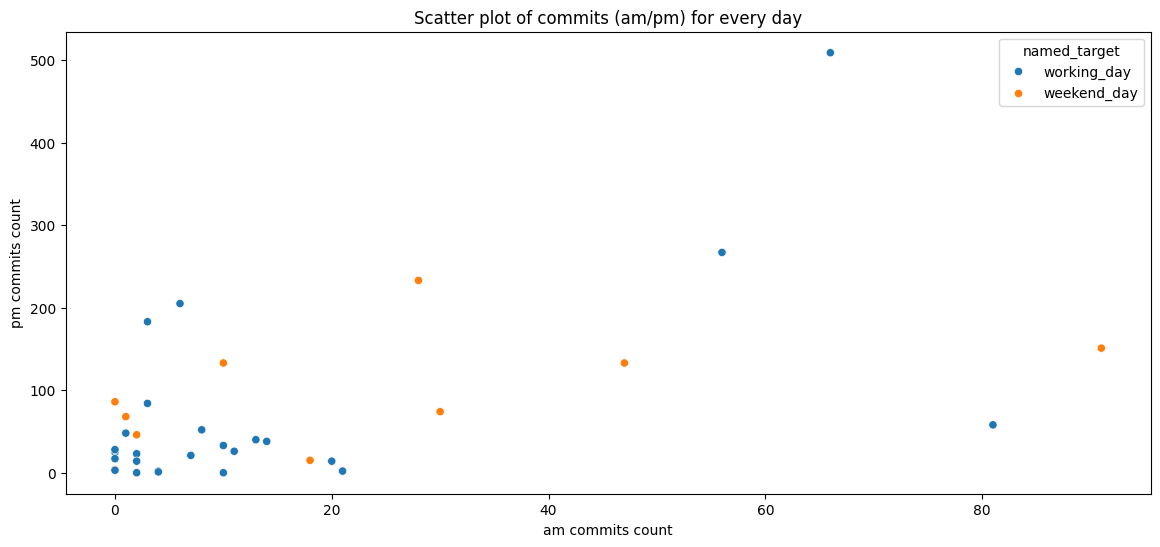

In [18]:
plt.figure(figsize=(14, 6, ), )
scatterplot(
    data=df,
    x="am",
    y="pm",
    hue="named_target",
)
plt.title("Scatter plot of commits (am/pm) for every day", )
plt.xlabel("am commits count", )
plt.ylabel("pm commits count", )
plt.show()

## `Do you think it will be easy to classify the days having those two features?`

Answer: no, it is not easy.

Create a model of *logistic regression*:

In [19]:
log_reg_model: LogisticRegression = LogisticRegression(
    random_state=21,
    fit_intercept=False,
)

Prepare features and target variables:

In [20]:
X: DataFrame = df[["am", "pm", ]]
y: Series = df["target"]

Check `X` and `y` variables:

In [21]:
X.head()

,am,pm
0,21,2
1,1,68
2,18,15
3,2,23
4,0,25


In [22]:
y.head()

0    0
1    1
2    1
3    0
4    0
Name: target, dtype: int64

## Train *logistic regression* model on `am` and `pm`, parameters are: `random state=21`, `fit_intercept=False`:

In [23]:
log_reg_model.fit(X, y, );

## Make predictions for every day and add them to *Pandas* dataframe with the column name `prediction`:

In [24]:
df["prediction"] = log_reg_model.predict(X, )

Create `named_prediciton` *Pandas* dataframe column for visualization:

In [25]:
df["named_prediction"] = df["prediction"].apply(
    lambda target: "working_day"
    if target == 0
    else "weekend_day",
)

Check `df` *Pandas* dataframe:

In [26]:
df.head()

,date,am,pm,target,named_target,naive_prediction,prediction,named_prediction
0,2020-04-17,21,2,0,working_day,0,1,weekend_day
1,2020-04-18,1,68,1,weekend_day,1,0,working_day
2,2020-04-19,18,15,1,weekend_day,0,0,working_day
3,2020-04-20,2,23,0,working_day,1,0,working_day
4,2020-04-21,0,25,0,working_day,1,0,working_day


## Draw plot like you did before, but the color should be taken from the `named_prediction`:

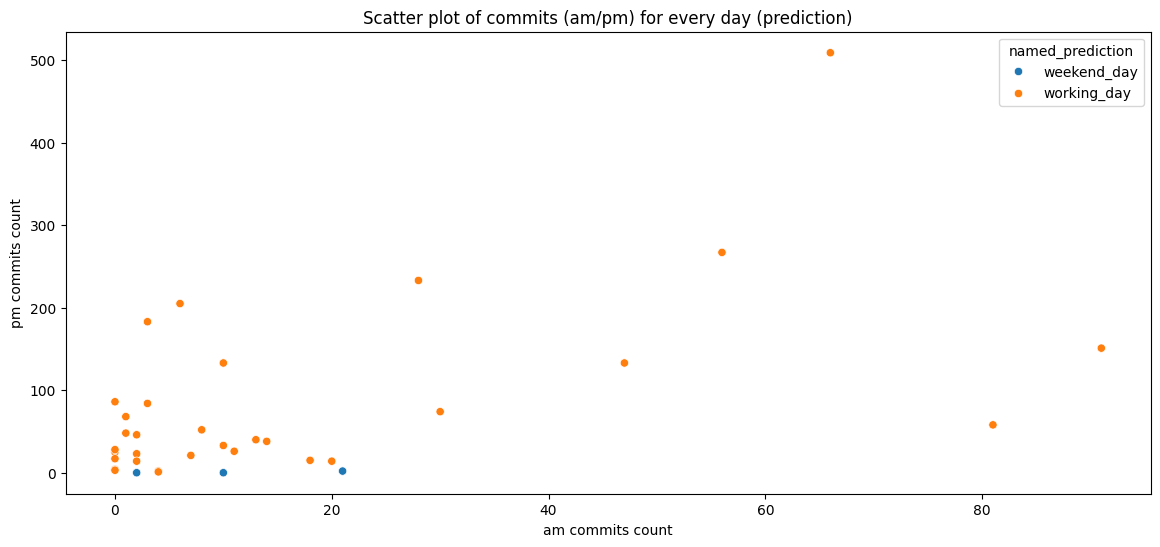

In [27]:
plt.figure(figsize=(14, 6, ), )
scatterplot(
    data=df,
    x="am",
    y="pm",
    hue="named_prediction",
)
plt.title("Scatter plot of commits (am/pm) for every day (prediction)", )
plt.xlabel("am commits count", )
plt.ylabel("pm commits count", )
plt.show()

## `Do you think if it made good predictions?`

Answer: no, it is not good.

## Calculate accuracy for predictions:

In [28]:
print(
    "The accuracy is:",
    round(
        accuracy_score(
            df["target"],
            df["prediction"],
        ),
        3,
    ),
)

The accuracy is: 0.629


## Calculate accuracy for the naive case:

In [29]:
print(
    "The accuracy is:",
    round(
        accuracy_score(
            df["target"],
            df["naive_prediction"],
        ),
        3,
    ),
)

The accuracy is: 0.457


## `Comparing the accuracies do you think that the classifier made good predictions?`

Answer: no, it is not good, but there are better then naive case predictions.

Create a dictionary for `to_csv()` method calling:

In [30]:
to_csv_params: dict[str , str] = {
    "file": "am_pm.csv",
    "file_path": "../../data/datasets/",
}

## Save the *Pandas* dataframe into the subfolder `data` with the name `am_pm.csv`:

In [31]:
df.drop(
    columns=["prediction", "named_prediction"],
).to_csv(
    to_csv_params["file_path"] + to_csv_params["file"],
)